In [481]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize, ListedColormap, LinearSegmentedColormap
import colorcet as cc
import os
from datetime import datetime
import json
from PIL import Image

# 0. Define In- and Output-Data

### 0.1 General Helpers:

In [482]:
def print_df(df: pd.DataFrame):
    """printing data in table for easy readable in console output.

    Args:
        df (pd.DataFrame): any Dataframe for visualization
    """
    
    df.columns = df.columns.str.replace(' ', '')
    
    # Determine column width (including index)
    widths = [max(len("t"), 10)] + [max(len(str(x)), 20) for x in df.columns]

    # Center header (including “Index” as column index)
    header = " | ".join(str(col).center(width) for col, width in zip(["t"] + list(df.columns), widths))

    # Center values (including row index)
    rows = "\n".join(
    " | ".join(str(val).center(width) for val, width in zip([index] + list(row), widths))
    for index, row in zip(df.index, df.values)
    )

    # Merge and output
    print(header)
    print("-" * len(header))  # Dividing line
    print(rows)
    
    
def change_energy_units(
    values: list, 
    actual_unit: str, 
    target_unit: str):
    """Iterates through a list of values (int/float) and checks unit. If actual and target units differ it processes 
    all values into new unit and gives back new list as return value.

    Args:
        values (list): power or energy values
        actual_unit (str): actual unit of input values
        target_unit (str): target unit for values

    Returns:
        list: target values with intended target unit.
    """
    
    target_values = []
    
    # Permitted units
    kW_units = ['kW', 'kWh']
    MW_units = ['MW', 'MWh']
    GW_units = ['GW', 'GWh']
    
    for value in values: 
        if actual_unit in kW_units and target_unit in MW_units: 
            target_values.append(round((value / 1000),2))
        elif actual_unit in kW_units and target_unit in GW_units:
            target_values.append(round((value / 1000000),2))
        elif actual_unit in kW_units and target_unit in kW_units:
            target_values.append(round((value),2))
        elif actual_unit in MW_units and target_unit in GW_units:
            target_values.append(round((value / 1000),2))
        elif actual_unit in MW_units and target_unit in kW_units:
            target_values.append(round((value * 1000),2))
        elif actual_unit in MW_units and target_unit in MW_units:
            target_values.append(round((value),2))
        elif actual_unit in GW_units and target_unit in MW_units:
            target_values.append(round((value * 1000),2))
        elif actual_unit in GW_units and target_unit in kW_units:
            target_values.append(round((value * 1000000),2))
        elif actual_unit in GW_units and target_unit in GW_units:
            target_values.append(round((value),2))
        else: 
            raise KeyError("Unit not found. Check spelling or add unit in function.")
    
    # print(f"Calculation done for actual unit: {actual_unit} to target unit: {target_unit}")

    return target_values


def get_weeks_from_timestamp(
    timestamps: list
    ):
    """generates weeks from input-dates by cutting string and find out KW. Result is a list of Strings. 
    Useful for plotting diagrams based on weeks and not months.

    Args:
        timestamps (list): list of timestamps in format: ['YYYY-MM-DD/YYYY-MM-DD', ...] if weeks are set as granularity.

    Returns:
        list: list with strings of weeknumber [01, 02, 03, ...] based on startdate (suitbale for x axis)
    """
    weeks = []
    for timestamp in timestamps:
        start_str = timestamp.split('/')[0]  # note only the start value before the '/'
        
        # Convert start date to datetime
        start_date = datetime.strptime(start_str, "%Y-%m-%d")
        
        # Retrieve calendar week
        start_week = start_date.isocalendar()[1]
        weeks.append(start_week)
        
    return weeks


def get_months_from_timestamp(
    timestamps: list
    ):
    """Adjust the strings contained by default for the month, 
    by deleting the year and leaving only the month as a string.

    Args:
        timestamps (list): input timestamps in list ['YYYY-MM', ...]

    Returns:
        list: converted list with months as strings
    """
    months = []
    for timestamp in timestamps:
        year = timestamp[:4]
        months.append(timestamp.replace(f'{year}-', ''))

    return months

### 0.2 Helpers for Colormaps

neue farbe für: solar_panel: [0.12156863 0.46666667 0.70588235 1.        ]
neue farbe für: wind_turbine: [0.17254902 0.62745098 0.17254902 1.        ]
neue farbe für: battery_storage: [0.58039216 0.40392157 0.74117647 1.        ]
neue farbe für: hydro_power: [0.89019608 0.46666667 0.76078431 1.        ]
neue farbe für: geothermal: [0.7372549  0.74117647 0.13333333 1.        ]


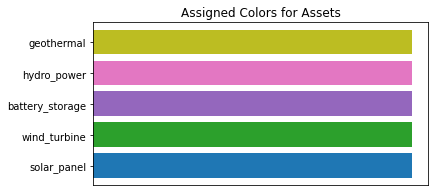

In [500]:
def register_colormap(cmap_name: str):
    """load colormap from plt and register in plt if colormap from cc.

    Args:
        cmap_name (str): colormap name as string registered in plt or cc.

    Returns:
       LinearSegmentedColormap : loaded colormap from plt.
    """
    if cmap_name not in plt.colormaps():
        colormap = cc.cm[cmap_name]  # load colormap from colorcet
        plt.register_cmap(name=cmap_name, cmap=ListedColormap(colormap(np.linspace(0, 1, 256))))  # only if not available register colormap
    else:
        colormap = plt.get_cmap(cmap_name) # if already registered in matplotlib load map from there.
    return colormap


def shift_colormap(
    cmap_name:str, 
    start=0.0, 
    end=1.0,
    amount_colors = 256
    ):
    """
    Checks whether the specified colormap is a cc and must be registered for plt or can be loaded directly. 
    Returns a new colormap that only contains a partial area of the original colormap. Default: 0 and 1.
    
    Args:
        cmap_name (str): Name of the original colormap.
        spectrum_left(float): starting point of colormap (0.0 = left, 1.0 = right). Defaults to 0.
        spectrum_right (float): end point of colormap (0.0 = left, 1.0 = right). Defaults to 1.
        amount_colors (int): Amounts of colors extracted from map. Defaults to 256.
    
    Returns:
        LinearSegmentedColormap: adjusted colormap.
    """
    colormap = register_colormap(cmap_name=cmap_name)
    return LinearSegmentedColormap.from_list(f"{cmap_name}_adjusted", colormap(np.linspace(start, end, amount_colors)))


def darken_colormap(
    cmap_name:str, 
    factor:float,
    spectrum_left = 0.0,
    spectrum_right = 1.0,
    amount_colors = 256
    ):
    """
    Darkens the color map by scaling the RGB values.
    
    Args:
        cmap (Colormap): original colormap.
        factor (float): Scaling factor (0.0 = dark, 1.0 = original colors).
        spectrum_left(float): starting point of colormap (0.0 = left, 1.0 = right). Defaults to 0.
        spectrum_right (float): end point of colormap (0.0 = left, 1.0 = right). Defaults to 1.
        amount_colors (int): Amounts of colors extracted from map. Defaults to 256.
    
    Returns:
        LinearSegmentedColormap: adjusted colormap.
    """

    colormap = register_colormap(cmap_name=cmap_name)
    colors = colormap(np.linspace(spectrum_left, spectrum_right, amount_colors))     # Create a list of colors
    darkened_colors = colors.copy()     # Create a copy of the colors
    darkened_colors[:, :3] *= factor    # Only scale RGB values, alpha remains the same
    return LinearSegmentedColormap.from_list(f"{cmap_name}_darkened", darkened_colors)


def get_color_for_key(
    asset_name: str, 
    cmap_name:str, 
    assigned_colors:dict,
    spectrum_left = 0.0,
    spectrum_right = 1.0,
    amount_colors = 256
    ):
    """Assign colors for assets and save in dictionary with assigned_colors.

    Args:
        asset_name (str): String of asset name.
        cmap_name (str): colormap from which assets get colors assigned to
        assigned_colors (dict): existing color dictionary (can also be empty at the beginning)
        spectrum_left(float): starting point of colormap (0.0 = left, 1.0 = right). Defaults to 0.
        spectrum_right (float): end point of colormap (0.0 = left, 1.0 = right). Defaults to 1.
        amount_colors (int): Amounts of colors extracted from map. Defaults to 256.

    Returns:
        tuple: color tuple for one asset with color values in rgba data (values between 0 and 1).
    """
    colormap = register_colormap(cmap_name=cmap_name)
    colors = colormap(np.linspace(spectrum_left, spectrum_right, amount_colors))
    asset_name_split = asset_name.split(".")[0]
    if asset_name_split not in assigned_colors:
        # If key does not have a color, give it the next one: 
        next_color = len(assigned_colors) % len(colors)  # cyclic iterating through colormap
        assigned_colors[asset_name_split] = colors[next_color]
        print(f"neue farbe für: {asset_name_split}:", colors[next_color])
    return tuple(assigned_colors[asset_name_split])


def load_color_data_from_json(
    colors_file: str, 
    output_path: str
    ):
    """
    Loads color values for assets from a JSON file. If the file does not exist
    or is invalid, an empty dictionary is returned.

    Args:
        colors_file (str): name of JSON-file.
        output_path (str): path of saving output file.

    Returns:
        Tuple[dict, str]: Dictionary with the color assignments and file path.
    """
    input_file = os.path.join(output_path, colors_file)
    
    if os.path.exists(input_file):
        try:
            with open(input_file, "r") as file:
                assigned_colors = json.load(file)
            
            # Convert lists back into tuples
            assigned_colors = {key: tuple(value) for key, value in assigned_colors.items()}
        except (json.JSONDecodeError, ValueError):  # Intercept errors during loading
            print(f"Warnung: {input_file} ist beschädigt oder ungültig. Erstelle ein leeres Dictionary.")
            assigned_colors = {}
    else:
        print(f"Datei {input_file} existiert nicht. Erstelle ein neues Dictionary.")
        assigned_colors = {}

    return assigned_colors, input_file
    

def save_colors_for_key_json(
    colors_file: str, 
    assigned_colors: dict
    ):
    """
    Saves the dictionary with the color assignments in a JSON file.

    Args:
        colors_file (str): path of JSON-file.
        assigned_colors (dict): Dictionary with color assignments.
    """
    # convert NumPy-Arrays in lists
    serializable_colors = {key: value.tolist() if isinstance(value, np.ndarray) else value
                           for key, value in assigned_colors.items()}
    
    # save JSON file
    with open(colors_file, "w") as file:
        json.dump(serializable_colors, file, indent=4)
        
    print(f"JSON file saved as: {colors_file}")


def show_color_rgba(
    rgba_values:tuple
    ):
    """Show a color in form of rgba with values between 0 and 1.

    Args:
        rgba_values (tuple): 4 values of rgba between 0 and 1.
    """
    rgba_color_255 = tuple(int(color * 255) for color in rgba_values)
    image = Image.new("RGBA", (100, 100), rgba_color_255)
    image.show()


### 0.3 Load data from CSV Output:

In [484]:
# 0.3 Load DataFrame of CSV as input-data: 
def load_csv_results_in_df(
    input_path: str
    ):
    """Load output csv in dataframe.

    Args:
        input_path (str): path from which csv is loaded. 

    Returns:
        pd.DataFrame: csv data in dataframe as table type.
    """
    
    input_values_df = pd.read_csv(input_path, index_col=0)
    # print_df(input_values_df) #################### ausführen!
    
    return input_values_df


# 1. Functions for filtering and calculating values for set time granularity

In [485]:
def add_timestamp_and_filter(
    input_df = pd.DataFrame, 
    start_date = str, 
    end_date = str, 
    time_column = 'date'
    ):
    """Insert Dates (YYYY-MM-DD) in DataFrame and filter after given start and end date.
    Assumption: 8784 values (366 days) beginning at 01.01.2025. If necessary needs to be 
    flexibilized.

    Args:
        df (pd.DataFrame, optional): Input Dataframe from results. Defaults to pd.DataFrame.
        start_date (str, optional): first date for filtering. Defaults to str.
        end_date (str, optional): end date for filtering. Defaults to str.
        time_column (str, optional): name of column with time steps. Default value 'date'.

    Returns:
        pd.DataFrame: added colomn with dates and filtered Dataframe after time span.
    """
    # Create List of dates and hours belonging to timestep:
    dates = list(pd.date_range('2025-01-01', periods=8784, freq='H'))
    input_df.insert(0, time_column, dates, allow_duplicates=False)
    input_df[time_column] = pd.to_datetime(input_df[time_column])
    
    # Delete blank spaces of colomn names:
    input_df.columns = input_df.columns.str.replace(' ', '')
    
    # filtered df after time span:
    return input_df[(input_df[time_column] >= pd.Timestamp(start_date)) & (input_df[time_column] <= pd.Timestamp(end_date))]


def sums_by_granularity(
    input_df: pd.DataFrame, 
    granularity: str, 
    time_column = 'date',
    period_column = 'period'
    ):
    """group lines of dataframe to given granularity (years, months etc.) and 
    sum up values of columns beginning from second column.

    Args:
        input_df (pd.DataFrame, optional): Dataframe with existing time_column. Defaults to pd.DataFrame.
        granularity (str, optional): time granularity: hours, days, weeks, month, years. Defaults to str.
        time_column (str, optional): Name of column with time data. Default value 'date'.
        period_column (str, optional): Name of column with set period (month, weeks ...). Default value 'period'.

    Raises:
        ValueError: if another granularity is given than defined no groups can 
        be formed.

    Returns:
        pd.DataFrame: filtered DataFrame with relevant time span and granularity. Sums are calculated for time spans. 
    """
    
    df = input_df.copy()
    df[time_column] = pd.to_datetime(df[time_column])
    if granularity == 'month':
        df[period_column] = df[time_column].dt.to_period('M')
    elif granularity == 'year':
        df[period_column] = df[time_column].dt.to_period('Y')
    elif granularity == 'week':
        df[period_column] = df[time_column].dt.to_period('W')
    elif granularity == 'day':
        df[period_column] = df[time_column].dt.to_period('D')
    elif granularity == 'hour':
        df[period_column] = df[time_column].dt.to_period('H')
    else:
        raise ValueError("Invalid time granularity.")
    
    # calculate the totals from the 2nd column, index period is reset and round to 2 digits.
    time_sums_df = df.groupby(period_column).sum().iloc[:, 2:].reset_index().round(2) 
    time_sums_df[period_column] = time_sums_df[period_column].astype(str)  # convert periods to string format
    
    return time_sums_df


def calculate_sums_for_period(
    input_df: pd.DataFrame, 
    start_date: str, 
    end_date: str, 
    granularity: str, 
    time_column='date',
    period_column='period'
    ):
    """Wrapper function: add and filter time values and sum up all values for time span and set granularity.

    Args:
        input_df (pd.DataFrame): Input Dataframe with all data from csv "output_time_series.csv"
        start_date (str): Start date for visualization. Format: 'YYYY-MM-DD'
        end_date (str): end date for visualization. Format: 'YYYY-MM-DD'
        granularity (str): granularity of time: "hours", "days", "weeks", "months", "years".
        time_column (str, optional): name of column with time data. Defaults to 'date'.
        period_column (str, optional): name of column with set period. Defaults to 'period'.

    Returns:
        pd.DataFrame: filtered dataframe after time and granularity and summed up data. 
    """
    time_filtered_df = add_timestamp_and_filter(
        input_df=input_df, 
        start_date=start_date, 
        end_date=end_date, 
        time_column=time_column
        )
    
    return sums_by_granularity(
        input_df=time_filtered_df, 
        granularity=granularity, 
        time_column=time_column, 
        period_column=period_column
        )

# 2. Functions for setting assets and parameters to be visualized

In [486]:
def extract_assets_to_dict(
    time_series_df: pd.DataFrame, 
    assets: tuple, 
    type_of_energy: str
    ):
    """
    Reads certain columns associated with all relevant assets for the diagram from a DataFrame 
    and saves them in a dictionary.

    Parameters:
        time_series_df (pd.DataFrame): DataFrame, with all asset data summed up for certain granularity and time span.
        assets (tuple): A tuple with all assets that are to be displayed.
        type_of_energy (str): The type of energy that is relevant and can be read out with the assets.

    Returns:
        dict: A dictionary with the column names of the assets and the energy type according to the format 
        '{asset}.{type_of_energy}' as keys and the column values as an associated list.
    """
    # Generate the complete column names
    column_names = [f"{asset}.{type_of_energy}" for asset in assets]

    # Filter the desired columns:
    extracted_columns_dict = {col: list(time_series_df[col]) for col in column_names if col in time_series_df.columns}
    
    return extracted_columns_dict


def calculate_asset_share_of_supply(
    asset_dict: dict,
    selected_assets: tuple,
    type_of_energy: str
    ):
    """Calculates the share of selected assets in the total supply of all specified assets. 

    Args:
        asset_dict (dict): all asset keys and their supply.
        selected_assets (tpl): selected assets for showing their share of total supply.
        type_of_energy: (str): type of energy (heat, power etc.)
        
    Returns:
        dict: New dict. The keys for the total demand per period have been added: 
        total_supply.{type_of_energy}, corresponding shares of selected assets with key 'share_of_assets' in percent and 
        selected_assets_supply.{type_of_energy} in actual unit.
        
    """
    supply_share_dict = {}
    # set keys: 
    share_key = "share_of_assets"
    total_supply_key = f"total_supply.{type_of_energy}"
    selected_supply_key = f"selected_assets_supply.{type_of_energy}"
    
    # Sum the values of the individual lists one after the other
    total_values = [sum(values) for values in zip(*asset_dict.values())]
    supply_share_dict[total_supply_key] = total_values
    # Check whether the selected assets (keys) are contained in the dict, 
    # add up their values and save them in the Dict.
    selected_values = [0] * len(total_values)

    # if assetname is in key sum up supply values and save in list.
    for key in asset_dict.keys():
        for asset in selected_assets:
            if asset in key:
                selected_values = [sum(values) for values in zip(selected_values, asset_dict[key])]
    
    # save supply for selected assets
    supply_share_dict[selected_supply_key] = selected_values
    
    # Determine the share of the supply of assets in the total value in percent. 
    share_values = [round((selected / total * 100),1) if total != 0 else 0 
                        for selected, total in zip(selected_values, total_values)]
    
    # save share of selected assets on total supply in dict.
    supply_share_dict[share_key] = share_values
    print("Shares of assets on supply: ", supply_share_dict)
    return supply_share_dict


def get_periods_for_plot(
    time_series_df: pd.DataFrame,  
    period_column = 'period'
    ):
    """Add a key with set period and time data to dictionary.

    Args:
        time_series_df (pd.DataFrame): Input Dataframe with filtered values and groups.
        period_column (str, optional): name of column with set period. Defaults to 'period'.

    Raises:
        KeyError: period needs to be an column name of DataFrame.

    Returns:
        list: period data for visualization in plot.
    """
    if period_column in time_series_df:
        periods = time_series_df[period_column].tolist()
    else: 
        raise KeyError("period not found in time_series_df.")
    return periods


def get_asset_data_for_plot(
    time_series_df: pd.DataFrame,
    all_assets: tuple,
    selected_assets: tuple, 
    type_of_energy: str, 
    actual_unit = 'MWh', 
    target_unit = 'GWh'
):
    """Wrapper function: Extract relevant asset data from input to asset_dict as y values for box plot. 
    Generate supply_dict with total supply, supply of selected assets and their share on total supply in percent. 
    Value is labeled in box plot diagram. Extract time periods as values for x axis.

    Args:
        time_series_df (pd.DataFrame): Loaded data from csv. Already filtered and summed up for given start and end date and set time granularity.
        all_assets (tuple): input tuple of all assets that will be considered in plot. 
        selected_assets (tuple): my selected assets for which share of supply is calculated f. e. RES or District Heating.
        type_of_energy (str): Power, heat, CO2 or other type of energy that will be plotted.
        actual_unit (str, optional): Unit of input data. Defaults to 'MWh'.
        target_unit (str, optional): Target unit of plotted data. Defaults to 'GWh'.

    Returns:
        asset_dict: Dictionary with relevant asset data like keys and supply in target unit. 
        supply_shares_dict: supplies in actual unit and share in percent of selected assets.
        periods: list of time periods für x axis in box plot.
    """ 
    
    # get keys for all assets and get their supply. Save in dict.
    asset_dict = extract_assets_to_dict(
        time_series_df=time_series_df,
        assets=all_assets,
        type_of_energy=type_of_energy
        )
    print(f"Dict in {actual_unit}:  ", asset_dict)

    # print("Asset Keys: ", asset_dict.keys())
    
    # print("Supply Shares Dict: ", supply_shares_dict)
    
    # Calculated supply from actual unit in target unit and overwrite values: 
    for key in asset_dict.keys():
        asset_dict[key] = change_energy_units(values=asset_dict[key], actual_unit=actual_unit, target_unit=target_unit)
    print(f"Dict in {target_unit}: ", asset_dict) 
    
    return asset_dict, calculate_asset_share_of_supply(asset_dict=asset_dict, selected_assets=selected_assets,type_of_energy=type_of_energy), get_periods_for_plot(time_series_df=time_series_df)


# 3. Functions for plotting and saving bar chart for share of assets

In [487]:

def plot_shares_of_supply(
    asset_dict: dict,
    supply_shares_dict: dict,
    assigned_asset_colors:dict,
    colormap:str,
    periods: list,
    granularity: str,
    type_of_energy: str,
    sharename: str,
    fontsize: int,
    title_size: int,
    key_to_label: str,
    target_unit: str
    ):
    """Function for plotting supply of assets as stacked bars. Unit and time granularity is determined, 
    colors are loaded for assets, label is set for share of interested assets like district heating or RES. 
    Return a figure of plt for saving next step.

    Args:
        asset_dict (dict): all asset keys and their supply.
        supply_shares_dict (dict): total_supply, corresponding shares of selected 
        assets with key 'share_of_assets' in percent and selected_assets_supply in 
        actual unit.
        assigned_asset_colors (dict): Dictionary with the color assignments
        colormap (str): Name of colormap
        periods (list): periods set for x axis.
        granularity (str): granularity of time.
        type_of_energy (str): energy type (heat, power etc.)
        sharename (str): name of share to be plotted (RES, District Heating, Solar_thermal etc.)
        fontsize (int): size of font in diagram
        title_size (int): size of font from diagram title.
        key_to_label (str): asset names for which share needs to be calculated.
        target_unit (str): energy unit (default: GWh)

    Returns:
        fig: Diagram figure from plt.
    """
    
    # width of plotted bar
    bar_width = 0.5

    # Positions of the time data on the x-axis
    # Conversion to a suitable display format:
    if granularity == 'month':
        periods_adjusted = get_months_from_timestamp(timestamps=periods)
    elif granularity == 'week':
        periods_adjusted = get_weeks_from_timestamp(timestamps=periods)
    else: periods_adjusted = periods

    x_pos = np.arange(len(periods_adjusted))

    # Create plot for Box plot
    fig, ax = plt.subplots(figsize=(11, 6), facecolor="white")

    # Initialization for the offset of the stacked bars
    offsets = np.zeros(len(periods_adjusted))
    for asset, values in asset_dict.items():
    
    # Get the color for the current asset
        color_asset = get_color_for_key(
            asset_name=asset, 
            assigned_colors=assigned_asset_colors, 
            cmap_name=colormap,
            amount_colors=8
            )
        
        # Draw the bars for the current asset
        bars = ax.bar(
            x_pos,             # positions on x axis
            values,             # values for heigh of bar
            width=bar_width,   # width of bar
            label=asset,       # label of bar
            color=color_asset,     # color of asset
            bottom=offsets,    # Offset for stacked bars
            zorder=2
        )
        
        # Show values directly on boxplot:
        if asset == key_to_label:
            # Show values from 'share_of_assets'
            for j, bar in enumerate(bars):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # x position (centered on bar)
                    bar.get_height() + offsets[j],      # y position (above bar)
                    f"{supply_shares_dict['share_of_assets'][j]:.2f}%",  # value of 'share_of_assets'
                    ha='center', va='bottom',  # center text
                    fontsize=fontsize
                    )
        # update offset for next level
        offsets += values
    # axis and labels
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5, zorder=1) 
    ax.set_xlabel(f"time in {granularity}s", fontsize=fontsize, fontweight='bold')
    ax.set_ylabel(f"supply of {type_of_energy} in {target_unit}", fontsize=fontsize, fontweight='bold')
    
    # set title for different amounts of assets (shifting legend height):
    if len(asset_dict) <= 3: 
        y_title = 1.1
    elif 4 <= len(asset_dict) < 7: 
        y_title = 1.2
    elif 7 <= len(asset_dict) < 10: 
        y_title = 1.3
    elif 10 <= len(asset_dict) < 13: 
        y_title = 1.4
    else: 
        raise("too many assets, y title not set. ")
    
    # set labels of plot: 
    ax.set_title(f"Shares of {sharename} on {type_of_energy} supply per {granularity}", fontsize=title_size, fontweight='bold', y=y_title)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(periods_adjusted)
    ax.tick_params(axis='x', labelsize=fontsize) 
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.legend(
        loc="lower center",           # position of legend
        bbox_to_anchor=(0.5, 1.0),   # anchor point (x=0.5 for central, y=1.0 for above)
        ncol=3,                      # amount of columns in legend
        frameon=True,                # Frame around legend
        fontsize=fontsize,
        title_fontsize=fontsize
        )

    # show diagram
    plt.tight_layout()
    return fig


def save_plot(
    fig, 
    output_path: str, 
    filename: str, 
    dpi: int = 300, 
    format: str = "png"
    ):
    """Saves the given plot in a file.

    Args:
        fig (matplotlib.figure.Figure): The diagram to be saved.
        output_path (str): Path to folder for saving file.
        filename (str): The file name (incl. path) for the saved file.
        dpi (int): The resolution of the picture.
        format (str): Data formate (f. e. "png", "pdf", "svg").
    """
    output_file = os.path.join(output_path, filename)
    plt.savefig(
        output_file, 
        format=format, 
        dpi=dpi, 
        facecolor="white", 
        transparent=False
        )
    plt.show()
    plt.close(fig)
    print(f"Diagram saved as: {output_file}")

# 04 Main: Generating Diagram for Shares of Supply

### Input values:

In [488]:
# 1 General Definition of variables:
granularity = str 
visualized_assets = list
assets_for_share = list

# 2 Definition Pathes, file and folder names for diagram:
output_folder_name = 'share_of_assets'
filename = 'share_of_assets_colortest_power_lsw.png'
colors_filename = "assigned_colors.json"
INPUT_PATH = '../data/output/output_time_series.csv'
OUTPUT_PATH = '../data/postprocessing/' + output_folder_name

# 3 Input constants for visualization:
my_assets = ('solar_thermal',) # heat: solar_thermal, arc11_expanded, power: arc01_expanded, pv
all_considered_assets = ('chp_1', 'chp_2', 'solar_thermal', 'arc11_expanded') # heat: 'solar_thermal', 'arc11_expanded', 'arc12_expanded', 'arc16_expanded'
type_of_energy = 'heat'
actual_unit = 'MWh'
target_unit = 'GWh'
granularity = 'month'
time_column = 'date'
start_date = '2025-01-01'
end_date = '2025-12-31'

# 0.4 Texts for visualization:
sharename = 'RES' 
key_to_label = f'solar_thermal.{type_of_energy}'

# 0.5 other settings for visualization: 
fontsize = 14
title_size = 16
colormap = 'nipy_spectral'
# color_shift_left = 0.2 # 0 normaler linker Rand der colormap
# color_shift_right = 0.9 # 0 normaler rechter Rand der colormap
# darken_factor = 0.7 # wie viel dunkler power ggü heat sein soll

### Skript: 

Dict in MWh:   {'chp_1.heat': [34979.89, 32361.9, 25778.98, 19223.22, 12245.96, 11340.73, 9768.26, 10108.83, 12129.1, 21932.15, 22222.31, 24261.46], 'chp_2.heat': [36625.8, 32706.87, 27691.71, 21009.41, 15262.89, 12683.76, 9724.32, 10538.86, 14599.05, 23375.59, 23545.53, 25016.08], 'solar_thermal.heat': [122.87, 145.54, 397.56, 595.38, 1116.44, 1008.61, 998.47, 967.57, 618.84, 311.81, 125.25, 66.42], 'arc11_expanded.heat': [36625.8, 32706.87, 27691.71, 21009.41, 15262.89, 12683.76, 9724.32, 10538.86, 14599.05, 23375.59, 23545.53, 25016.08]}
Dict in GWh:  {'chp_1.heat': [34.98, 32.36, 25.78, 19.22, 12.25, 11.34, 9.77, 10.11, 12.13, 21.93, 22.22, 24.26], 'chp_2.heat': [36.63, 32.71, 27.69, 21.01, 15.26, 12.68, 9.72, 10.54, 14.6, 23.38, 23.55, 25.02], 'solar_thermal.heat': [0.12, 0.15, 0.4, 0.6, 1.12, 1.01, 1.0, 0.97, 0.62, 0.31, 0.13, 0.07], 'arc11_expanded.heat': [36.63, 32.71, 27.69, 21.01, 15.26, 12.68, 9.72, 10.54, 14.6, 23.38, 23.55, 25.02]}
Shares of assets on supply:  {'total_supp

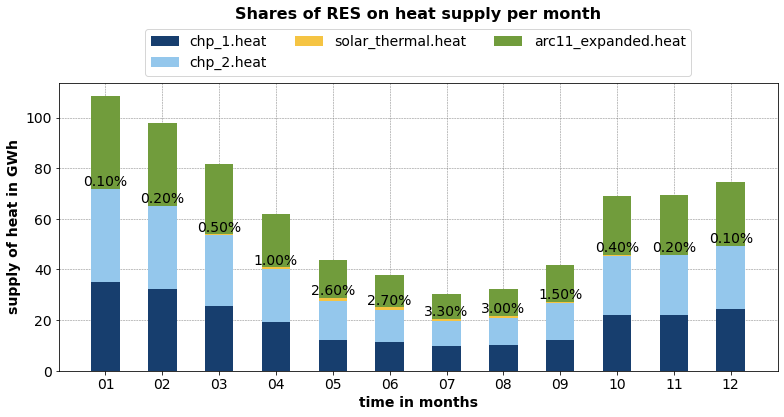

Diagram saved as: ../data/postprocessing/share_of_assets/share_of_assets_colortest_power_lsw.png
JSON file saved as: ../data/postprocessing/share_of_assets/assigned_colors.json


In [489]:
# 1 Load Data from csv INPUT PATH: 
time_sums_df = calculate_sums_for_period(
    input_df=load_csv_results_in_df(input_path = INPUT_PATH), 
    start_date = start_date, 
    end_date = end_date, 
    granularity=granularity, 
    time_column=time_column
    )

# print_df(time_sums_df)

# 2 Process data fitting for box plot visualization: 
asset_plot_dict, supply_shares_dict, periods = get_asset_data_for_plot(
    time_series_df=time_sums_df, 
    all_assets=all_considered_assets,
    selected_assets=my_assets,
    type_of_energy=type_of_energy,
    actual_unit=actual_unit,
    target_unit=target_unit
)

# print("asset_plot_dict: ", asset_plot_dict)

# 3 load colors from json file: 
colors_dict, color_file_json = load_color_data_from_json(
    colors_file=colors_filename, 
    output_path=OUTPUT_PATH
    )

# print("colors dict", colors_dict)

# 4 plot shares of set assets in input data: 
box_plot_share_RES = plot_shares_of_supply(
    asset_dict= asset_plot_dict, 
    supply_shares_dict = supply_shares_dict,
    granularity=granularity,
    type_of_energy=type_of_energy,
    sharename=sharename,
    fontsize=fontsize,
    title_size=title_size,
    key_to_label=key_to_label,
    periods = periods,
    target_unit = target_unit,
    colormap=colormap,
    assigned_asset_colors=colors_dict
    )

# 5 save figure of plot in # 4.
save_plot(
    fig=box_plot_share_RES,
    output_path=OUTPUT_PATH,
    filename=filename 
)

# 6 save colors if new asset is added: 
save_colors_for_key_json(
    colors_file=color_file_json, 
    assigned_colors=colors_dict
    )



Generiere ein Diagramm über die Zeit von allen Assets und dem Bedarf sowie der Differenz, die im Speicher landet

In [490]:
    #     # Farben für die Assets: Eigene Colormap aus bestehender erstellen (shift) und abdunkeln für Strom:
    # my_colormap = shitf_colormap(colormap, start=color_shift_left, end=color_shift_right)   # links
    # plt.register_cmap(name=f"{colormap}_adjusted", cmap=my_colormap) # damit verdunkeln möglich
    # # cmap_darker = darken_colormap(cmap_name=f'{colormap}_adjusted', factor=darken_factor)
    # # cmap_original = plt.get_cmap(colormap)
    # norm = Normalize(vmin=0, vmax=len(asset_dict))  # Normalisierung auf Anzahl der Assets
    # # cmap_shifted = shift_colormap(colormap, start=color_shift_left, end=color_shift_right)  # angepasster Colormap-Bereich
    
    # if type_of_energy == 'heat':
    #     colors = [my_colormap(norm(i)) for i in range(len(asset_dict))] # kontinuierliche Farbpalette
    # elif type_of_energy == 'power':
    #     cmap_darker = darken_colormap(cmap_name=f'{colormap}_adjusted', factor=darken_factor)  # Dunklere Colormap
    #     colors = [cmap_darker(norm(i)) for i in range(len(asset_dict))]  # Dunklere Farben
    # elif type_of_energy == 'co2': 
    #     colors = [plt.cm.cubehelix(i / len(asset_dict)) for i in range(len(asset_dict))] # kontinuierliche Farbpalette
    # elif type_of_energy == 'gas':
    #     colors = [plt.cm.gist_earth(i / len(asset_dict)) for i in range(len(asset_dict))] # kontinuierliche Farbpalette
    # else: 
    #     colors = [plt.cm.my_colormap(i / len(asset_dict)) for i in range(len(asset_dict))] # kontinuierliche Farbpalette